In [146]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
from numba import jit, njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root
from scipy.special import erfc
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
from scipy.integrate import simps

In [42]:
@njit(parallel=True)
def InF_ani(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    ipara_r = np.zeros(len(n0))
    ipara_i = np.zeros(len(n0))

    for i in prange(len(n0)):
        if n0[i] == 0:
            continue
        bra = v_para[0]**2+v_perp[0]/2
        den_i = omega[1]
        den_r = omega[0] - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[0]**2
        exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
        f_r = (dn0[i]+n0[i]*bra)*den_r*exp/(den_r**2+den_i**2)
        f_i = -(dn0[i]+n0[i]*bra)*den_i*exp/(den_r**2+den_i**2)
        iperp0_r = 0
        iperp0_i = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = v_para[0]**2+v_perp[l]/2
            den_i = omega[1]
            den_r = omega[0] - in0[i] - kl_perp*v_perp[l]/2 - kl_para*v_para[0]**2
            exp = np.exp(-v_para[0]**2/2-v_perp[l]/2)
            f0_r = f_r
            f0_i = f_i
            f_r = (dn0[i]+n0[i]*bra)*den_r*exp/(den_r**2+den_i**2)
            f_i = -(dn0[i]+n0[i]*bra)*den_i*exp/(den_r**2+den_i**2)
            iperp0_r = iperp0_r + dperp*(f_r+f0_r)/2
            iperp0_i = iperp0_i + dperp*(f_i+f0_i)/2
        for j in range(1, lr):
            bra = v_para[j]**2+v_perp[0]/2
            den_i = omega[1]
            den_r = omega[0] - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[j]**2
            exp = np.exp(-v_para[j]**2/2-v_perp[0]/2)
            f_r = (dn0[i]+n0[i]*bra)*den_r*exp/(den_r**2+den_i**2)
            f_i = -(dn0[i]+n0[i]*bra)*den_i*exp/(den_r**2+den_i**2)
            iperp_r = 0
            iperp_i = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = v_para[j]**2+v_perp[k]/2
                den_i = omega[1]
                den_r = omega[0] - in0[i] - kl_perp*v_perp[k]/2 - kl_para*v_para[j]**2
                exp = np.exp(-v_para[j]**2/2-v_perp[k]/2)
                f0_r = f_r
                f0_i = f_i
                f_r = (dn0[i]+n0[i]*bra)*den_r*exp/(den_r**2+den_i**2)
                f_i = -(dn0[i]+n0[i]*bra)*den_i*exp/(den_r**2+den_i**2)
                iperp_r = iperp_r + dperp*(f_r+f0_r)/2
                iperp_i = iperp_i + dperp*(f_i+f0_i)/2
            ipara_r[i] = ipara_r[i] + (v_para[j]-v_para[j-1])*(iperp_r+iperp0_r)/2
            ipara_i[i] = ipara_i[i] + (v_para[j]-v_para[j-1])*(iperp_i+iperp0_i)/2
            iperp0_r = iperp_r
            iperp0_i = iperp_i
            
    return ipara_r, ipara_i

In [43]:
R1 = 0.2
R2 = 8
r = np.linspace(R1, R2, 1000)
l = len(r)
dr = (np.max(r)-np.min(r))/(l-1)

n0 = (8/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
n_spl = Spline(r, n0, k = 3)
dn = n_spl.derivative()
rdn = r*dn(r)
nr2_spl = Spline(r, r**2*n0, k = 3)
dnr2 = nr2_spl.derivative()
dnr2 = dnr2(r)
rn_spl = Spline(r, r*n0, k = 3)
irn = rn_spl.antiderivative()
irn = irn(r)

In [44]:
kl = 0.1
kl_perp = kl
kl_para = kl
omega = (3, 0.5)

diag_ani_r, diag_ani_i = InF_ani(5, 300, irn, dnr2/r-2*n0, n0, omega, kl_perp, kl_para)


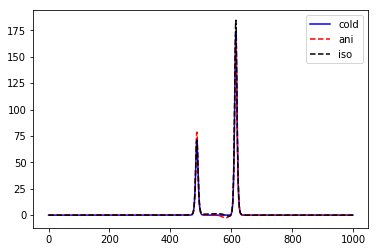

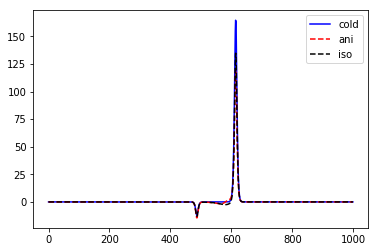

In [45]:
a = kl/(irn-omega[0]-omega[1]*1j)
Erfc = erfc(1/np.sqrt(2*(a)))
ana = np.sqrt(2*np.pi)*np.pi*np.exp(1/a)*Erfc**2/(2*a)
inf_r = np.real(ana)
inf_i = np.imag(ana)
diag_iso = (inf_r+1j*inf_i)*(dnr2/(omega[0]+1j*omega[1]-irn)+n0/kl)/np.sqrt(2*np.pi) - n0/kl
diag_cold_r = (dnr2*(omega[0]-irn))/(r*((omega[0]-irn)**2 + omega[1]**2))
diag_cold_i = -(dnr2*omega[1])/(r*((omega[0]-irn)**2 + omega[1]**2))

plt.plot(np.sqrt(6*np.pi)*diag_cold_r, 'b', label="cold")
plt.plot(diag_ani_r*np.sqrt(np.pi), 'r', label="ani", linestyle="dashed")
plt.plot(np.real(diag_iso), 'k', label="iso", linestyle="dashed")
plt.legend()
plt.show()
plt.plot(np.sqrt(6*np.pi)*diag_cold_i, 'b', label="cold")
plt.plot(diag_ani_i*np.sqrt(np.pi), 'r', label="ani", linestyle="dashed")
plt.plot(np.imag(diag_iso), 'k', label="iso", linestyle="dashed")
plt.legend()
plt.show()

In [46]:
#Poisson Solver
@njit(parallel=True)
def M(r, dr):
    col = np.zeros(3*len(r)-4)
    row = np.zeros(3*len(r)-4)
    data = np.zeros(3*len(r)-4)
    data[0] = 1
    for i in prange(1, len(r)-1):
        row[3*i-1:3*i+2] = i
        col[3*i-1] = i-1
        col[3*i] = i
        col[3*i+1] = i+1
        data[3*i-1] = (r[i]-dr/2)/(dr**2*r[i])
        data[3*i] = -2/dr**2
        data[3*i+1] = (r[i]+dr/2)/(dr**2*r[i])
    row[-1] = len(r)-1
    col[-1] = len(r)-1
    data[-1] = len(r)-1
    return data, col, row

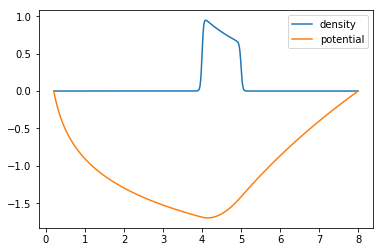

In [97]:
data, col, row = M(r, dr)
A = csc_matrix((data, (row, col)), shape=(len(r), len(r)))
lu = sla.splu(A)

n0 = (8/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
phi = lu.solve(n0)
n_spl = Spline(r, n0, k = 3)
dn = n_spl.derivative()
dn = dn(r)
rdn = r*dn
nr2_spl = Spline(r, r**2*n0, k = 3)
dnr2 = nr2_spl.derivative()
dnr2 = dnr2(r)
rn_spl = Spline(r, r*n0, k = 3)
irn = rn_spl.antiderivative()
irn = irn(r)

plt.plot(r, n0, label='density')
plt.plot(r, phi, label='potential')
plt.legend()
plt.show()

#n0_p = (7.9/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
n0_p = np.zeros(len(r))
n0_m = n0-n0_p

dn0_p = np.zeros(len(r))
in0_m = np.zeros(len(r))

dn0_p[0] = (r[1]+r[0])*(n0_p[1] - n0_p[0])/(2*dr)
in0_m[0] = dr*(r[1]*n0_m[1] + r[0]*n0_m[0])/2
for i in range(len(r)-1):
    dn0_p[i] = (r[i+1]+r[i])*(n0_p[i+1] - n0_p[i])/(2*dr)
    in0_m[i] = in0_m[i-1] + dr*(r[i+1]*n0_m[i+1] + r[i]*n0_m[i])/2
dn0_p[-1] = 2*dn0_p[-2] - dn0_p[-3]
in0_m[-1] = 2*in0_m[-2] - in0_m[-3]

In [48]:
def shooting(r, dr, dnr2, irn, omega):
    @njit
    def fun(omega):

        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = ((r[i]-dr/2)/(dr**2*r[i]))
            drm = -2/dr**2
            drr = -((dr**2*r[i])/(r[i]+dr/2))
            diag_real = (dnr2[i]*(omega[0]-irn[i]))/(r[i]*((omega[0]-irn[i])**2 + omega[1]**2))
            diag_imag = (dnr2[i]*omega[1])/(r[i]*((omega[0]-irn[i])**2 + omega[1]**2))

            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [111]:
def shooting_complex(r_complex, dr_complex, dnr2_conti, irn_conti, omega):
    @njit
    def fun(omega):
        phi = np.zeros(len(r_complex)-1, dtype=np.complex_)
        phi[1] = 1 + 1j
        for i in range(2, len(r_complex)-1):
            drl = ((r_complex[i]-(dr_complex[i-1])/2)/((dr_complex[i])**2*(r_complex[i])))
            drm = -2/(dr_complex[i-1])**2
            drr = -(((dr_complex[i-1])**2*(r_complex[i]))/((r_complex[i])+(dr_complex[i-1])/2))
            diag = dnr2_conti[i]/((r_complex[i-1])*(omega[0] + 1j*omega[1] - irn_conti[i])) 

            phi_2 = drl*phi[i-2]
            phi_1 = (drm + diag - 1)*phi[i-1]
            phi[i] = drr*(phi_2 + phi_1)  

        return np.real(phi[-1]), np.imag(phi[-1])
    
    Root = root(fun, omega)
    return(Root)

In [204]:
def shooting_complex(r_complex, dr_complex, dnr2, irn, omega):
    #@jit
    def fun(omega):
        diag_real = (dnr2*(omega[0]-irn))/(r*((omega[0]-irn)**2 + omega[1]**2))
        diag_imag = (dnr2*omega[1])/(r*((omega[0]-irn)**2 + omega[1]**2))
        diag_real_spl = Spline(r, diag_real, k = 3)
        diag_imag_spl = Spline(r, diag_imag, k = 3)
        ddiag_real_spl = diag_real_spl.derivative()
        ddiag_imag_spl = diag_imag_spl.derivative()
        ddiag_imag = np.imag(r_complex)*ddiag_real_spl(r)
        ddiag_real = np.imag(r_complex)*ddiag_imag_spl(r)
        diag = diag_real - ddiag_real + 1j*(diag_imag + ddiag_imag)
        phi = np.zeros(len(r_complex)-1, dtype=np.complex_)
        phi[1] = 1 + 1j
        for i in range(2, len(r_complex)-1):
            #drl = ((r_complex[i]-(dr_complex[i-1])/2)/((dr_complex[i])**2*(r_complex[i])))
            #drm = -2/(dr_complex[i-1])**2
            #drr = -(((dr_complex[i-1])**2*(r_complex[i]))/((r_complex[i])+(dr_complex[i-1])/2))

            drl = (r_complex[i]+r_complex[i-1])/(2*r_complex[i]*(dr**2-(r_imag[i+1]-r_imag[i-1])*(r_imag[i]-r_imag[i-1]) + 1j*dr*(r_imag[i+1]-r_imag[i])))
            drr = -(2*r_complex[i]*(dr**2-(r_imag[i+1]-r_imag[i-1])*(r_imag[i+1]-r_imag[i]) + 1j*dr*(r_imag[i]-r_imag[i-1])))/(r_complex[i+1]+r_complex[i])
            drm = -drl+1/drr
    
            phi_2 = drl*phi[i-2]
            phi_1 = (drm + diag[i] - 1)*phi[i-1]
            phi[i] = drr*(phi_2 + phi_1)  

        return np.real(phi[-1]), np.imag(phi[-1])
    
    Root = root(fun, omega)
    return(Root)

In [50]:
def hot_shooting(r, dr, n0, rdn, irn, kl, omega):
    def fun(omega):
        a = kl/(irn-omega[0]-omega[1]*1j)
        Erfc = erfc(1/np.sqrt(2*(a)))
        ana = np.sqrt(2*np.pi)*np.pi*np.exp(1/a)*Erfc**2/(2*a)
        inf_r = np.real(ana)
        inf_i = np.imag(ana)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            den = ((irn[i]-omega[0])**2 + omega[1]**2)
            diag = (inf_r[i]+1j*inf_i[i])*(rdn[i]/(omega[0]+1j*omega[1]-irn[i])+n0[i]/kl)/np.sqrt(2*np.pi) - n0[i]/kl
            diag_real = np.real(diag)
            diag_imag = np.imag(diag)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] - diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] + diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [51]:
def ani_shooting(r, dr, n0, rdn, irn, kl_perp, kl_para, omega):
    @njit
    def fun(omega):
        diag_real, diag_imag = InF_ani(5, 100, irn, rdn, n0, omega, kl_perp, kl_para)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - diag_imag[i]*phi_i[i-1]/np.sqrt(2*np.pi)
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + diag_imag[i]*phi_r[i-1]/np.sqrt(2*np.pi)
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [52]:
def mixed_shooting(r, dr, n0_n, n0_p, rdn_n, rdn_p, irn_m, kl_perp, kl_para, omega):
    @njit
    def fun(omega):

        diag_real_n, diag_imag_n = InF_ani(5, 300, irn_m, rdn_n, n0_n, omega, kl_perp, kl_para)
        diag_real_p, diag_imag_p = InF_ani(5, 300, irn_m, rdn_p, n0_p, omega, -kl_perp, -kl_para)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

    fjac: array([[-0.75466065,  0.65611531],
       [-0.65611531, -0.75466065]])
     fun: array([ 6.10472513e-11, -1.92676403e-09])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-2.46292819e-06,  4.63381741e-06])
       r: array([-10588.05153696,     54.99771   , -10513.44725162])
  status: 1
 success: True
       x: array([1.991027  , 0.66645612])
[0.9955135  0.33322806]


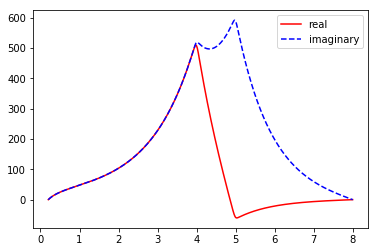

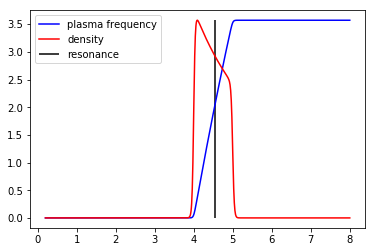

In [120]:
bullet = shooting(r, dr, dnr2, irn, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dnr2[i]*(omega[0]-irn[i]))/(r[i]*((omega[0]-irn[i])**2 + omega[1]**2))
    diag_imag = (dnr2[i]*omega[1])/(r[i]*((omega[0]-irn[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(irn-omega[0]))

plt.plot(r, irn, "b", label='plasma frequency')
plt.plot(r, np.max(irn)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(irn), np.max(irn), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[ 0.65552145, -0.75517655],
       [ 0.75517655,  0.65552145]])
     fun: array([-1.67495865e-09,  7.38283675e-10])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-3.46966571e-06, -5.54653693e-06])
       r: array([-10501.02482763,     69.37222135,  10378.49216903])
  status: 1
 success: True
       x: array([1.99024409, 0.66613176])


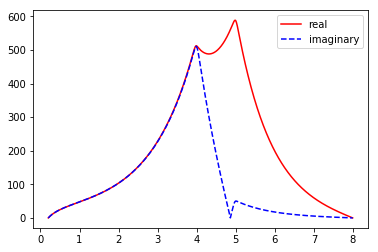

In [209]:
s = np.linspace(0, 1, len(r))

r_imag = s*(1-s)*4
s0 = np.min(abs(n0[n0>0]/dn[n0>0]))
r_imag = -s0*r_imag
dr_imag = r_imag[1:] - r_imag[:-1]
r_complex = r + 1j*r_imag
dr_complex = dr + 1j*dr_imag

bullet = shooting_complex(r_complex, dr_complex, dnr2, irn, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

diag_real = (dnr2*(omega[0]-irn))/(r*((omega[0]-irn)**2 + omega[1]**2))
diag_imag = (dnr2*omega[1])/(r*((omega[0]-irn)**2 + omega[1]**2))
diag_real_spl = Spline(r, diag_real, k = 5)
diag_imag_spl = Spline(r, diag_imag, k = 5)
ddiag_real_spl = diag_real_spl.derivative()
ddiag_imag_spl = diag_imag_spl.derivative()
ddiag_imag = np.imag(r_complex)*ddiag_real_spl(r)
ddiag_real = np.imag(r_complex)*ddiag_imag_spl(r)
diag = diag_real - ddiag_real + 1j*(diag_imag + ddiag_imag)

phi = np.zeros(len(r_complex)-1, dtype=np.complex_)
phi[1] = 1 + 1j

for i in range(2, len(r_complex)-1):
    drl = (r_complex[i]+r_complex[i-1])/(2*r_complex[i]*(dr**2-(r_imag[i+1]-r_imag[i-1])*(r_imag[i]-r_imag[i-1]) + 1j*dr*(r_imag[i+1]-r_imag[i])))
    drr = -(2*r_complex[i]*(dr**2-(r_imag[i+1]-r_imag[i-1])*(r_imag[i+1]-r_imag[i]) + 1j*dr*(r_imag[i]-r_imag[i-1])))/(r_complex[i+1]+r_complex[i])
    drm = -drl+1/drr

    phi_2 = drl*phi[i-2]
    phi_1 = (drm + diag[i] - 1)*phi[i-1]
    phi[i] = drr*(phi_2 + phi_1)  

plt.plot(r[:-1], abs(np.real(phi)), "r", label='real')
plt.plot(r[:-1], abs(np.imag(phi)), "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

In [56]:
stop

NameError: name 'stop' is not defined

    fjac: array([[-0.75445319,  0.65635386],
       [-0.65635386, -0.75445319]])
     fun: array([-1.48405469e-10, -1.08096816e-11])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.94993275e-07, -1.15879661e-06])
       r: array([-5.53880501e+03, -4.01790836e+00, -5.53588552e+03])
  status: 1
 success: True
       x: array([2.19196448, 0.61384049])
[1.09598224 0.30692025]


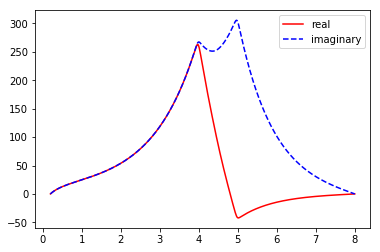

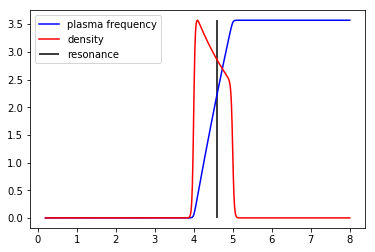

In [ ]:
kl = 0.1

bullet = hot_shooting(r, dr, n0, rdn, irn, kl, np.array([2.0, 0.6]))
print(bullet)
omega = bullet.x

a = kl/(-omega[0]-omega[1]*1j+irn)
Erfc = erfc(1/np.sqrt(2*(a)))
ana = np.sqrt(2*np.pi)*np.pi*np.exp(1/a)*Erfc**2/(2*a)
inf_r = np.real(ana)
inf_i = np.imag(ana)
#inf_r, inf_i = InF(5, 100, a)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    den = ((irn[i]-omega[0])**2 + omega[1]**2)
    #diag_real = (inf_r[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl) - inf_i[i]*(dn0_hot[i]*omega[1])/den)/np.sqrt(2*np.pi) - n0[i]/kl
    #diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1])/den + inf_i[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl))/np.sqrt(2*np.pi)
    diag = (inf_r[i]+1j*inf_i[i])*(rdn[i]/(omega[0]+1j*omega[1]-irn[i])+n0[i]/kl)/np.sqrt(2*np.pi) - n0[i]/kl
    diag_real = np.real(diag)
    diag_imag = np.imag(diag)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] - diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] + diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(irn-omega[0]))

plt.plot(r, irn, "b", label='plasma frequency')
plt.plot(r, np.max(irn)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(irn), np.max(irn), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[-0.75462996,  0.65615061],
       [-0.65615061, -0.75462996]])
     fun: array([ 3.76041653e-12, -1.00734329e-10])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.89354791e-07, -1.09398775e-06])
       r: array([-5.54224683e+03, -3.99832524e+00, -5.53943580e+03])
  status: 1
 success: True
       x: array([2.19124077, 0.6144794 ])
[1.09562039 0.3072397 ]


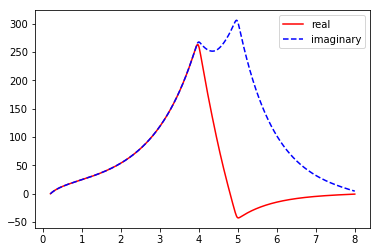

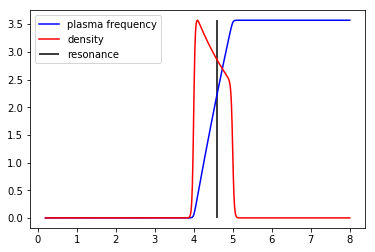

In [ ]:
kl_perp = 0.1
kl_para = 0.1

bullet = ani_shooting(r, dr, n0, rdn, irn, kl_perp, kl_para, np.array([2.0, 0.6]))
print(bullet)
omega = bullet.x

diag_real, diag_imag = InF_ani(5, 300, irn, rdn, n0, omega, kl_perp, kl_para)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - diag_imag[i]*phi_i[i-1]/np.sqrt(2*np.pi)
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + diag_imag[i]*phi_r[i-1]/np.sqrt(2*np.pi)
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(irn-omega[0]))

plt.plot(r, irn, "b", label='plasma frequency')
plt.plot(r, np.max(irn)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(irn), np.max(irn), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[ 0.73883294, -0.67388863],
       [ 0.67388863,  0.73883294]])
     fun: array([-1.47586657e-10, -1.43836411e-10])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([4.26284425e-07, 3.95319834e-06])
       r: array([6.07655312e+03, 1.96609369e+00, 6.07556829e+03])
  status: 1
 success: True
       x: array([2.04526214, 0.54664699])
[1.02263107 0.27332349]


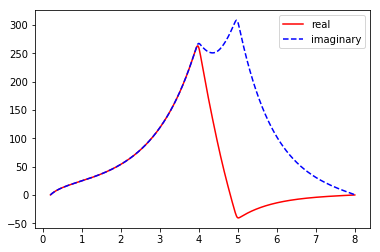

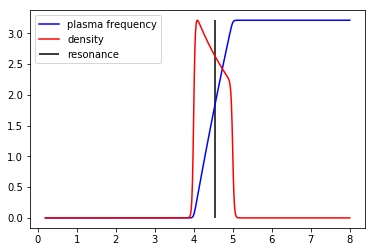

In [ ]:
n0_n = n0
n0_p = 0.1*n0
n_spl_n = Spline(r, n0_n, k = 3)
dn_n = n_spl_n.derivative()
rdn_n = r*dn_n(r)
n_spl_p = Spline(r, n0_p, k = 3)
dn_p = n_spl_p.derivative()
rdn_p = r*dn_p(r)
rn_spl = Spline(r, r*(n0_n-n0_p), k = 3)
irn_m = rn_spl.antiderivative()
irn_m = irn_m(r)

bullet = mixed_shooting(r, dr, n0_n, n0_p, rdn_n, rdn_p, irn_m, kl_perp, kl_para, np.array([1.0, 1.0]))
print(bullet)
omega = bullet.x
diag_real_n, diag_imag_n = InF_ani(5, 500, irn_m, rdn_n, n0_n, omega, kl_perp, kl_para)
diag_real_p, diag_imag_p = InF_ani(5, 500, irn_m, rdn_p, n0_p, omega, -kl_perp, -kl_para)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(irn-omega[0]))

plt.plot(r, irn_m, "b", label='plasma frequency')
plt.plot(r, np.max(irn_m)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(irn_m), np.max(irn_m), "k", label='resonance')
plt.legend()
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
kl_perp = 0.1
kl_para = 0.1
ratio = [0.8, 0.9]#np.linspace(0.0, 1.0, 11)
r_in = 4
r_out = 5
i_out = np.argmin(abs(r-r_out))
omega0 = np.array([1, 0.3])
omega_i = np.zeros(len(ratio))
omega_r = np.zeros(len(ratio))

for i in range(len(ratio)):   # function returns a 2D data array
    n0_n = r**-2*(np.tanh(25*(r-r_in))-np.tanh(25*(r-r_out)))/np.log(r_out/r_in)
    n0_p = ratio[i]*r**-2*(np.tanh(25*(r-r_in))-np.tanh(25*(r-r_out)))/np.log(r_out/r_in)
    n_spl_n = Spline(r, n0_n, k = 3)
    dn_n = n_spl_n.derivative()
    rdn_n = r*dn_n(r)
    n_spl_p = Spline(r, n0_p, k = 3)
    dn_p = n_spl_p.derivative()
    rdn_p = r*dn_p(r)
    rn_spl = Spline(r, r*(n0_n-n0_p), k = 3)
    irn_m = rn_spl.antiderivative()
    irn_m = irn_m(r)

    bullet = mixed_shooting(r, dr, n0_n, n0_p, rdn_n, rdn_p, irn_m, kl_perp, kl_para, np.array([1.0, 1.0]))
    omega = bullet.x
    print(bullet)
    diag_real_n, diag_imag_n = InF_ani(5, 300, irn_m, rdn_n, n0_n, omega, kl_perp, kl_para)
    diag_real_p, diag_imag_p = InF_ani(5, 300, irn_m, rdn_p, n0_p, omega, -kl_perp, -kl_para)
    phi_r = np.zeros(len(r))
    phi_i = np.zeros(len(r))
    phi_r[1] = 1
    phi_i[1] = 1
    for i in range(2, len(r)):
        drl = (r[i]-dr/2)/(dr**2*r[i])
        drm = -2/dr**2
        drr = -(dr**2*r[i])/(r[i]+dr/2)
        phi_r2 = drl*phi_r[i-2]
        phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
        phi_r[i] = drr*(phi_r2 + phi_r1) 

        phi_i2 = drl*phi_i[i-2]
        phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
        phi_i[i] = drr*(phi_i2 + phi_i1)
    n1_r = A.dot(phi_r)
    n1_i = A.dot(phi_i)
    plt.plot(r, n1_r)
    plt.plot(r, n1_i, linestyle = "dashed")
    plt.show()

In [ ]:
kl_perp = 0.1
kl_para = 0.1
ratio = np.linspace(0.0, 1.0, 11)
r_in = 4
r_out = 5

fig = plt.figure()
ax = plt.axes(xlim=(r[0], r[-1]), ylim=(-1.1, 1.1))
ax.set_xlabel("Radius", fontsize = 15)
ax.set_ylabel("Density", fontsize = 15)
line, = ax.plot([], [], lw=2, label = "real")
line2, = ax.plot([], [], lw=2, label = "imag", linestyle = "dashed")
fig.legend()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    n0_n = r**-2*(np.tanh(25*(r-r_in))-np.tanh(25*(r-r_out)))/np.log(r_out/r_in)
    n0_p = ratio[i]*r**-2*(np.tanh(25*(r-r_in))-np.tanh(25*(r-r_out)))/np.log(r_out/r_in)
    n_spl_n = Spline(r, n0_n, k = 3)
    dn_n = n_spl_n.derivative()
    rdn_n = r*dn_n(r)
    n_spl_p = Spline(r, n0_p, k = 3)
    dn_p = n_spl_p.derivative()
    rdn_p = r*dn_p(r)
    rn_spl = Spline(r, r*(n0_n-n0_p), k = 3)
    irn_m = rn_spl.antiderivative()
    irn_m = irn_m(r)

    bullet = mixed_shooting(r, dr, n0_n, n0_p, rdn_n, rdn_p, irn_m, kl_perp, kl_para, np.array([1.0, 1.0]))
    omega = bullet.x
    diag_real_n, diag_imag_n = InF_ani(5, 500, irn_m, rdn_n, n0_n, omega, kl_perp, kl_para)
    diag_real_p, diag_imag_p = InF_ani(5, 500, irn_m, rdn_p, n0_p, omega, -kl_perp, -kl_para)
    phi_r = np.zeros(len(r))
    phi_i = np.zeros(len(r))
    phi_r[1] = 1
    phi_i[1] = 1
    for i in range(2, len(r)-1):
        drl = (r[i]-dr/2)/(dr**2*r[i])
        drm = -2/dr**2
        drr = -(dr**2*r[i])/(r[i]+dr/2)
        phi_r2 = drl*phi_r[i-2]
        phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
        phi_r[i] = drr*(phi_r2 + phi_r1) 

        phi_i2 = drl*phi_i[i-2]
        phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
        phi_i[i] = drr*(phi_i2 + phi_i1)
    n1_r = A.dot(phi_r)
    n1_i = A.dot(phi_i)
    line.set_data(r, n1_r/np.max(abs(n1_r)))
    line2.set_data(r, n1_i/np.max(abs(n1_i)))
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=11, interval=20, blit=True)
anim.save('pair_profiles.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
plt.show()

In [ ]:
stop

In [ ]:
#for kl in np.linspace(0, 1, 10):
kl = 0
i = 0
omega_i = np.zeros((20, 20))
for r_in in np.linspace(0.1, 2, 20):
    j = 0
    for r_out in np.linspace(r_in+0.1, 2+r_in, 20):
        R1 = 0.1
        R2 = 8
        r = np.linspace(R1, R2, 500)

        n0 = r**-2*(np.tanh(25*(r-r_in))-np.tanh(25*(r-r_out)))/np.log(r_out/r_in)
        n_spl = Spline(r, n0, k = 3)
        dn = n_spl.derivative()
        rdn = r*dn(r)
        rn_spl = Spline(r, r*n0, k = 3)
        irn = rn_spl.antiderivative()
        irn = irn(r)

        kl_perp = kl
        kl_para = kl

        bullet = ani_shooting(r, dr, n0, rdn, irn, kl_perp, kl_para, np.array([2.0, 0.6]))
        omega_i[i, j] = bullet.x[1]
        j += 1
    i += 1

In [ ]:
mask = np.zeros((20, 20))
mask[omega_i<=1e-2] = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

contours_o = np.arange(np.min(omega_i), np.max(omega_i)*1.1, (np.max(omega_i)*1.1-np.min(omega_i))/20)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)
contour_mask = np.arange(0, 1.1, 0.5)
#contour_a = np.arange(np.min(a), np.max(a), (np.max(a)-np.min(a))/30)

im = ax.contourf(np.linspace(1, 2, 20), np.linspace(0.1, 2, 20), np.transpose(omega_i), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
im_mask = ax.contour(np.linspace(1, 2, 20), np.linspace(0.1, 2, 20), np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=3)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega_i), np.max(omega_i)*1.1, (np.max(omega_i)*1.1-np.min(omega_i))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega_i), np.max(omega_i)*1.1, (np.max(omega_i)*1.1-np.min(omega_i))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$Im(\Omega_+)$',fontsize=20)
#plt.savefig('Tom_vs_Patrick.png', format = 'png', bbox_inches="tight", dpi=300)

In [ ]:
#for kl in np.linspace(0, 1, 10):
kl = 0.1
i = 0
omega_i = np.zeros((20, 20))
for r_in in np.linspace(0.1, 2, 20):
    j = 0
    for r_out in np.linspace(r_in+0.1, 2+r_in, 20):
        R1 = 0.1
        R2 = 8
        r = np.linspace(R1, R2, 500)

        n0 = r**-2*(np.tanh(25*(r-r_in))-np.tanh(25*(r-r_out)))/np.log(r_out/r_in)
        n_spl = Spline(r, n0, k = 3)
        dn = n_spl.derivative()
        rdn = r*dn(r)
        rn_spl = Spline(r, r*n0, k = 3)
        irn = rn_spl.antiderivative()
        irn = irn(r)

        kl_perp = kl
        kl_para = kl

        bullet = ani_shooting(r, dr, n0, rdn, irn, kl_perp, kl_para, np.array([2.0, 0.6]))
        omega_i[i, j] = bullet.x[1]
        j += 1
    i += 1

In [ ]:
mask = np.zeros((20, 20))
mask[omega_i<=1e-2] = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

contours_o = np.arange(np.min(omega_i), np.max(omega_i)*1.1, (np.max(omega_i)*1.1-np.min(omega_i))/20)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)
contour_mask = np.arange(0, 1.1, 0.5)
#contour_a = np.arange(np.min(a), np.max(a), (np.max(a)-np.min(a))/30)

im = ax.contourf(np.linspace(1, 2, 20), np.linspace(0.1, 2, 20), np.transpose(omega_i), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
im_mask = ax.contour(np.linspace(1, 2, 20), np.linspace(0.1, 2, 20), np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=3)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega_i), np.max(omega_i)*1.1, (np.max(omega_i)*1.1-np.min(omega_i))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega_i), np.max(omega_i)*1.1, (np.max(omega_i)*1.1-np.min(omega_i))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$Im(\Omega_+)$',fontsize=20)
#plt.savefig('Tom_vs_Patrick.png', format = 'png', bbox_inches="tight", dpi=300)

In [ ]:
kl_perp = 1
kl_para = 5e-1

bullet = mixed_shooting(r, dr, n0, n0_p, dn0_hot, dn0_p, in0_m, kl_perp, kl_para, np.array([1.0, 1.0]))
print(bullet)
omega = bullet.x
diag_real_n, diag_imag_n = Int_ani(5, 500, in0_m, dn0_hot, n0, omega, kl_perp, kl_para)
diag_real_p, diag_imag_p = Int_ani(5, 500, in0_m, dn0_p, n0_p, omega, -kl_perp, -kl_para)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

In [ ]:
stop

In [ ]:
for i in range(i_x):    
    for j in range(i+1, i+i_y):
            
            bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
            omega = bullet.x
            G11 = green[i, i]
            G22 = green[j, j]
            G12 = green[i, j]
            n0_norm = 1/np.log(r[j]/r[i])
            p = (G11 - G22 - np.log(r[j]/r[i]))/2
            q = (G12**2 - G11*G22 - np.log(r[j]/r[i])*G11)/4

            if (p/2)**2 > q:
                omega_p[i, j-i] = n0_norm*(-p/2 + np.sqrt((p/2)**2 - q))
                omega_m[i, j-i] = n0_norm*(-p/2 - np.sqrt((p/2)**2 - q))
            else:
                omega_p[i, j-i] = n0_norm*(-p/2 + 1j*np.sqrt(-(p/2)**2 + q))
                omega_m[i, j-i] = n0_norm*(-p/2 - 1j*np.sqrt(-(p/2)**2 + q))
    return omega_p, omega_m

In [ ]:
@njit(parallel=True)
def density_stuff(r, dr, n0):
    dn0 = np.zeros(len(r))
    in0 = np.zeros(len(r))

    for i in range(len(r)-1):
        dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
        in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dn0[-1] = 2*dn0[-2] - dn0[-3]
    in0[-1] = 2*in0[-2] - in0[-3]
    return dn0, in0

In [ ]:

r1 = np.linspace(0.2, 4, 20)
omega_r = np.empty(len(r1))
omega_i = np.empty(len(r1))
for i in range(len(r1)):
    n0 = (8/r**2)*(np.tanh(25*(r-r1[i]))-np.tanh(25*(r-5)))
    dn0, in0 = density_stuff(r, dr, n0)

    bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.1]))
    omega_r[i] = bullet.x[0]
    omega_i[i] = bullet.x[1]

plt.plot(r1, omega_r, "r*", label='real')
plt.plot(r1, omega_i, "bd", label='imaginary')
plt.ylabel("$\Omega$")
plt.xlabel("$\Xi_1$")
plt.legend()
plt.show()

In [ ]:
#n0 = (8/r**2)*(np.tanh(25*(r-0.2))-np.tanh(25*(r-5)))
n0 = (r**-2 - R2**-2)/R1**-2
dn0, in0 = density_stuff(r, dr, n0)

bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

In [ ]:
n0 = (r**-2 - R2**-2)/R1**-2

plt.plot(r, n0, "r", label='density')
plt.legend()
plt.show()
print(n0[-1])